In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder,OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import KFold
from sklearn.feature_selection import RFECV,RFE
from sklearn.pipeline import make_pipeline
import statsmodels.api as sm
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso


In [35]:
data = pd.read_csv("project_dataset_housing.csv")

In [36]:
# Display the first few rows of the dataset
print(data.head())

      price  area  bedrooms  bathrooms  stories mainroad guestroom basement  \
0  13300000  7420         4          2        3      yes        no       no   
1  12250000  8960         4          4        4      yes        no       no   
2  12250000  9960         3          2        2      yes        no      yes   
3  12215000  7500         4          2        2      yes        no      yes   
4  11410000  7420         4          1        2      yes       yes      yes   

  hotwaterheating airconditioning  parking prefarea furnishingstatus  
0              no             yes        2      yes        furnished  
1              no             yes        3       no        furnished  
2              no              no        2      yes   semi-furnished  
3              no             yes        3      yes        furnished  
4              no             yes        2       no        furnished  


In [37]:
#1. Data Preprocessing
# Encode binary categorical features as 0 and 1
binary_columns = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea']
data[binary_columns] = data[binary_columns].apply(lambda x: x.map({'yes': 1, 'no': 0}))

 
# Handle missing values for binary categorical columns
for col in binary_columns:
    # Check if there's at least one non-NaN entry
    if data[col].notna().any():
        # If there's at least one non-NaN entry, fill NaNs with the mode
        data[col].fillna(data[col].mode()[0], inplace=True)
    else:
        # If all entries are NaN, fill with a default value or consider dropping the column
        data[col].fillna(0, inplace=True)  # Assuming 0 can be a placeholder for 'no' or 'false'

# Assuming 'parking' is a numeric column where NaN indicates 'no parking', we fill NaNs with 0
data['parking'].fillna(0, inplace=True)

# One-hot encoding 'furnishingstatus' column
# First, confirm that 'furnishingstatus' is in the DataFrame
if 'furnishingstatus' in data.columns:
    # One-hot encoding 'furnishingstatus' column
    encoder = OneHotEncoder(sparse=False, drop='first')  # Avoiding multicollinearity by using drop='first'
    furnishingstatus_encoded = encoder.fit_transform(data[['furnishingstatus']])
    feature_names = encoder.get_feature_names_out(['furnishingstatus'])
    encoded_df = pd.DataFrame(furnishingstatus_encoded, columns=feature_names)

    # Now you can safely drop 'furnishingstatus' from 'data' as it's already encoded
    data.drop(['furnishingstatus'], axis=1, inplace=True)
else:
    print("furnishingstatus column is not in the DataFrame.")
# Combine the encoded columns with the rest of the dataset and drop the original 'furnishingstatus' column
 
data_encoded = pd.concat([data, encoded_df], axis=1)

# Now, calculate IQR for numeric columns and filter out outliers
numeric_columns = data_encoded.select_dtypes(include=[np.number])  # Only select numeric columns
Q1 = numeric_columns.quantile(0.25)
Q3 = numeric_columns.quantile(0.75)
IQR = Q3 - Q1

# Defining the condition for outliers
condition = ~((numeric_columns < (Q1 - 1.5 * IQR)) | (numeric_columns > (Q3 + 1.5 * IQR))).any(axis=1)

# Filter out outliers based on the condition
data_filtered = data_encoded[condition].reset_index(drop=True)
 
# Check for missing values again to confirm
missing_values = data_filtered.isnull().sum()
 
# Checking the descriptive statistics of the filtered data
summary_stats = data_filtered.describe()

missing_values, summary_stats

(price                              0
 area                               0
 bedrooms                           0
 bathrooms                          0
 stories                            0
 mainroad                           0
 guestroom                          0
 basement                           0
 hotwaterheating                    0
 airconditioning                    0
 parking                            0
 prefarea                           0
 furnishingstatus_semi-furnished    0
 furnishingstatus_unfurnished       0
 dtype: int64,
               price          area    bedrooms   bathrooms     stories  \
 count  2.370000e+02    237.000000  237.000000  237.000000  237.000000   
 mean   4.052838e+06   4676.185654    2.780591    1.164557    1.611814   
 std    1.276966e+06   1681.597943    0.690709    0.393713    0.604667   
 min    1.750000e+06   1700.000000    1.000000    1.000000    1.000000   
 25%    3.150000e+06   3570.000000    2.000000    1.000000    1.000000   
 50%    3

# Exploratory Data Analysis and Feature Engineering

### Distribution of Numerical Features

**Objective:**  
To understand the distribution of the numerical features (`area`, `bedrooms`, `bathrooms`, `stories`, `parking`) and decide on any necessary transformations.

**Process:**  
The `describe()` method is used to generate descriptive statistics that summarize the central tendency, dispersion, and shape of the dataset's distribution.

**Output:**  
`numerical_features_stats` provides a statistical summary for each numerical feature which aids in identifying skewness, outliers, and the distribution's nature (normal, skewed, etc.).

### Feature Selection for Regression Analysis

**Objective:**  
To select relevant features for predicting the house prices.

**Selection:**  
Features like `area`, `bedrooms`, `bathrooms`, and `stories` are chosen based on their potential influence on the house price.

**Outcome:**  
These features (`X`) will be used as independent variables to predict the dependent variable (`y`), which is the house price.

### Feature Engineering

**Objective:**  
To enhance the model's prediction ability by introducing polynomial features.

**Process:**  
Polynomial features of degree 2 are generated from the selected features to capture non-linear relationships between the features and the target variable.

**Outcome:**  
The transformed feature set `X_poly` is more complex and potentially more capable of capturing nuanced patterns in the data.

### Data Preprocessing

**Objective:**  
To standardize the feature set so that the model is not biased towards variables with higher magnitudes.

**Process:**  
Scaling is applied to the polynomial features to normalize their scale.

**Outcome:**  
`X_scaled` represents the standardized version of the polynomial features, ready for model training.

### Splitting the Dataset

**Objective:**  
To divide the dataset into training and testing sets to evaluate the model's performance.

**Process:**  
The dataset is split into training (80%) and testing (20%) sets, ensuring both sets are representative of the overall distribution.

**Outcome:**  
The training set (`X_train`, `y_train`) is used to fit the model, and the testing set (`X_test`, `y_test`) is used to evaluate its predictive performance.

### Size Check of Training and Testing Sets

**Objective:**  
To verify the size of the split datasets to ensure they are correctly partitioned.

**Outcome:**  
The shapes of `X_train`, `X_test`, `y_train`, and `y_test` are checked to confirm the dataset has been split as intended.

By performing these steps, the dataset is systematically prepared and transformed, making it suitable for building a robust regression model to predict house prices accurately.
       house prices accurately.rted.

In [38]:
# Check the distribution of the numerical features to decide on transformations
numerical_features = ['area', 'bedrooms', 'bathrooms', 'stories', 'parking']
numerical_features_stats = data_filtered[numerical_features].describe()

# Selecting features and target variable for regression analysis
features = ['area', 'bedrooms', 'bathrooms', 'stories']
X = data_filtered[features]
y = data_filtered['price']

# Feature Engineering: Adding polynomial features
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)

# Data Preprocessing: Scaling the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_poly)

# Splitting the dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Checking the size of the training and testing sets
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((189, 14), (48, 14), (189,), (48,))

In [39]:
 
#  Linear Regression with features as the independent variable and price as dependent variable
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
 
# Add a constant to the independent variables to include the intercept (bias) in the model
X_train_with_constant = sm.add_constant(X_train)

# Fit the OLS model using statsmodels
ols_model = sm.OLS(y_train, X_train_with_constant).fit()

# Retrieve the bias (intercept) term
bias = ols_model.params[0]

# Retrieve the coefficients
coefficients = ols_model.params[1:]

# Predict on the training data
y_train_pred = ols_model.predict(X_train_with_constant)

# Calculate the Mean Squared Error on the training data
mse_train = mean_squared_error(y_train, y_train_pred)

# Print the model summary
print(ols_model.summary())

# Output the bias and MSE
bias, mse_train


                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.454
Model:                            OLS   Adj. R-squared:                  0.410
Method:                 Least Squares   F-statistic:                     10.33
Date:                Wed, 17 Apr 2024   Prob (F-statistic):           9.96e-17
Time:                        16:30:39   Log-Likelihood:                -2866.2
No. Observations:                 189   AIC:                             5762.
Df Residuals:                     174   BIC:                             5811.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.118e+06    7.2e+04     57.177      0.0

(4118358.998312801, 870803636982.9335)

In [40]:
# Assuming X and y have been properly defined in the context where this code will run.
# Using 5-fold cross-validation to estimate MSE, RMSE, and R^2 for OLS regression

mse_cv_scores = []
rmse_cv_scores = []
r2_cv_scores = []

kf = KFold(n_splits=5, shuffle=True, random_state=42)

for train_index, test_index in kf.split(X):
    # Split into train and test sets for the fold
    X_train_cv, X_test_cv = X.iloc[train_index], X.iloc[test_index]
    y_train_cv, y_test_cv = y.iloc[train_index], y.iloc[test_index]
    
    # Add a constant term for intercept
    X_train_cv_const = sm.add_constant(X_train_cv)
    X_test_cv_const = sm.add_constant(X_test_cv)
    
    # Fit OLS model
    model = sm.OLS(y_train_cv, X_train_cv_const).fit()
    
    # Predict on test set
    y_pred_cv = model.predict(X_test_cv_const)
    
    # Calculate scores
    mse_cv = mean_squared_error(y_test_cv, y_pred_cv)
    rmse_cv = np.sqrt(mse_cv)
    r2_cv = r2_score(y_test_cv, y_pred_cv)
    
    # Append scores
    mse_cv_scores.append(mse_cv)
    rmse_cv_scores.append(rmse_cv)
    r2_cv_scores.append(r2_cv)

# Calculate average scores across all folds
avg_mse_cv = np.mean(mse_cv_scores)
avg_rmse_cv = np.mean(rmse_cv_scores)
avg_r2_cv = np.mean(r2_cv_scores)

avg_mse_cv, avg_rmse_cv, avg_r2_cv

(1040907111538.1166, 1013391.1789744555, 0.34472315401405185)

In [41]:

# Get the intercept and slope coefficient
b0 = linear_model.intercept_
b1 = linear_model.coef_[0]
print("Intercept (b0):", b0)
print("Slope coefficient (b1):", b1)

Intercept (b0): 4118358.998312804
Slope coefficient (b1): 111857.14301489861


In [42]:
 
# Predicting on training and testing sets
y_train_pred = linear_model.predict(X_train)
y_test_pred = linear_model.predict(X_test)


In [43]:
# Function to calculate Mean Squared Error (MSE)
def calculate_mse(y_actual, y_predicted):
    return np.mean((y_actual - y_predicted) ** 2)

# Calculate MSE for training and testing sets
mse_train = calculate_mse(y_train, y_train_pred)
mse_test = calculate_mse(y_test, y_test_pred)

mse_train, mse_test

(870803636982.9332, 1356014886914.1726)

In [44]:
# Function to calculate Root Mean Squared Error (RMSE)
def calculate_rmse(y_actual, y_predicted):
    mse = np.mean((y_actual - y_predicted) ** 2)
    return np.sqrt(mse)

# Calculate RMSE for training and testing sets
rmse_train = calculate_rmse(y_train, y_train_pred)
rmse_test = calculate_rmse(y_test, y_test_pred)

rmse_train, rmse_test

(933168.6005127548, 1164480.5223421182)

In [45]:
# Function to calculate R-squared
def calculate_r2(y_actual, y_predicted):
    ss_res = ((y_actual - y_predicted) ** 2).sum()  # Residual sum of squares
    ss_tot = ((y_actual - y_actual.mean()) ** 2).sum()  # Total sum of squares
    return 1 - (ss_res / ss_tot)

# Calculate R-squared for training and testing sets
r2_train = calculate_r2(y_train, y_train_pred)
r2_test = calculate_r2(y_test, y_test_pred)

r2_train, r2_test

(0.4539788686329098, 0.21807811381276165)

In [46]:
print ("Training  MSE :", mse_train, 
        "Training RMSE :", rmse_train,
        "Training R2 :", r2_train)
print ("Testing MSE:", mse_test,
       "Testing RMSE:",rmse_test,
       "Testing R2:" ,r2_test)

Training  MSE : 870803636982.9332 Training RMSE : 933168.6005127548 Training R2 : 0.4539788686329098
Testing MSE: 1356014886914.1726 Testing RMSE: 1164480.5223421182 Testing R2: 0.21807811381276165


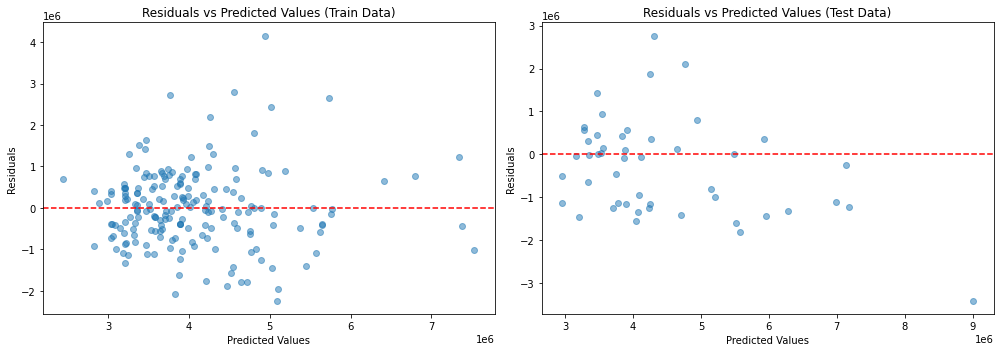

In [47]:
residuals_train = y_train - y_train_pred
residuals_test = y_test - y_test_pred

# Plotting residuals
plt.figure(figsize=(14, 5))

# Plot for training data
plt.subplot(1, 2, 1)
plt.scatter(y_train_pred, residuals_train, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Residuals vs Predicted Values (Train Data)')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')

# Plot for test data
plt.subplot(1, 2, 2)
plt.scatter(y_test_pred, residuals_test, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Residuals vs Predicted Values (Test Data)')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')

plt.tight_layout()
plt.show()




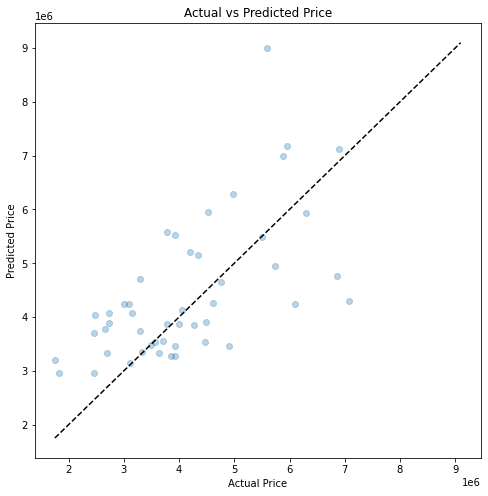

1356014886914.1711

In [48]:
# Predict on the test data
X_test_with_constant = sm.add_constant(X_test)
y_test_pred = ols_model.predict(X_test_with_constant)

# Calculate the Mean Squared Error on the test data
mse_test = mean_squared_error(y_test, y_test_pred)

# Plotting the model's predictions against actual prices
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_test_pred, alpha=0.3)
plt.plot([y.min(), y.max()], [y.min(), y.max()], '--k')  # A dashed diagonal line
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted Price')
plt.show()

# Output the Mean Squared Error on the test data
mse_test


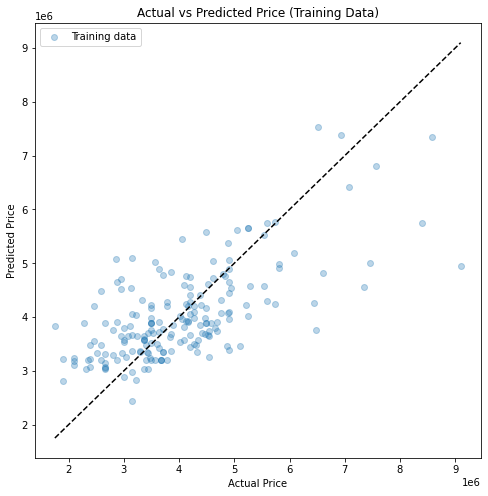

In [49]:
# Predicting with training data for visualization
y_train_pred = linear_model.predict(X_train)

# Plotting the model's predictions against actual prices for the training data
plt.figure(figsize=(8, 8))
plt.scatter(y_train, y_train_pred, alpha=0.3, label='Training data')
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], '--k')  # A dashed diagonal line
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted Price (Training Data)')
plt.legend()
plt.show()

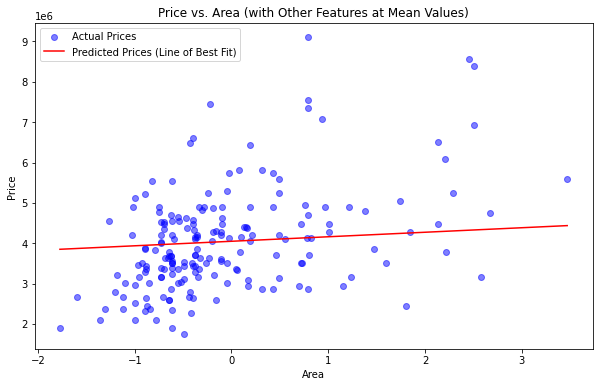

In [50]:
# Assuming ols_model is already trained and you've used statsmodels for training it.
# Calculate the mean of the features in the training data.
mean_values = X_train.mean(axis=0)

# Get the range for the 'area' feature.
area_min, area_max = X_train[:, features.index('area')].min(), X_train[:, features.index('area')].max()
area_range = np.linspace(area_min, area_max, 100)

# Prepare the feature data for predictions: set 'area' to its range and other features to their mean values.
X_pred = np.tile(mean_values, (100, 1))
X_pred[:, features.index('area')] = area_range

# Add a constant to the data for the intercept.
X_pred_with_constant = sm.add_constant(X_pred)

# Make predictions across the range of 'area'.
price_pred = linear_model.predict(X_pred_with_constant)

# Plotting the predictions against the 'area' feature.
plt.figure(figsize=(10, 6))
plt.scatter(X_train[:, features.index('area')], y_train, color='blue', alpha=0.5, label='Actual Prices')
plt.plot(area_range, price_pred, color='red', label='Predicted Prices (Line of Best Fit)')
plt.xlabel('Area')
plt.ylabel('Price')
plt.title('Price vs. Area (with Other Features at Mean Values)')
plt.legend()
plt.show()


In [51]:
# Lasso and Ridge Regression 

<AxesSubplot:>

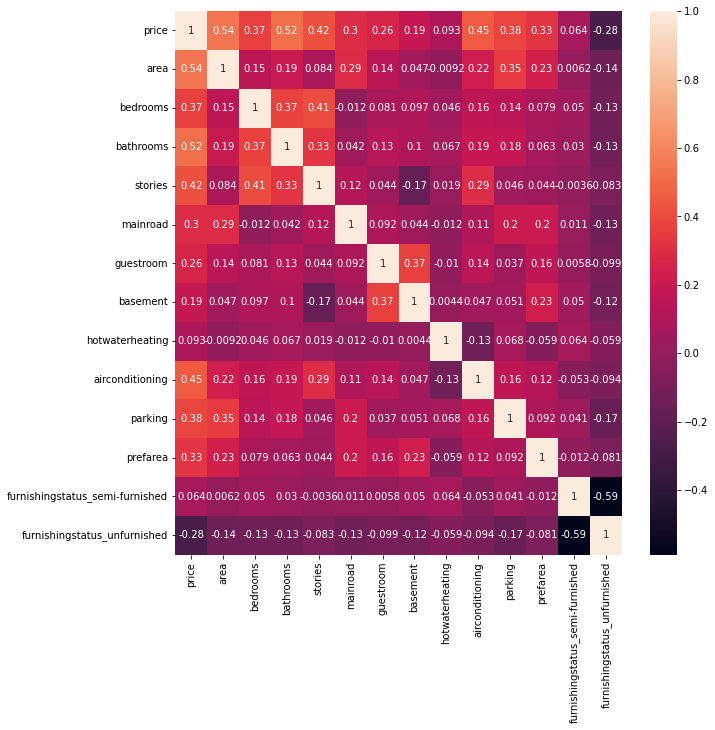

In [52]:
#Exploration

plt.figure(figsize = (10, 10))
sns.heatmap(data_encoded.corr(), annot = True)

In [53]:
Choose the Tuning Parameters (Regularization Multiplier λ) using cross-validation.
Present the Model with its Formula Clearly.
Plot Tuning Parameters versus Cross-Validation Error to visually select the best λ.
Test the Model on the Testing Dataset and report the error.

SyntaxError: invalid syntax (2026207566.py, line 1)

In [ ]:
# Assume X_train and X_test are defined
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
## Define a range of lambda values
alpha_range = np.logspace(-6, 6, 13)

# Setup the model
ridge = Ridge()

# Setup the grid search with cross-validation
param_grid = {'alpha': alpha_range}
ridge_cv = GridSearchCV(ridge, param_grid, cv=5, scoring='neg_mean_squared_error')

# Perform the grid search on the scaled training data
ridge_cv.fit(X_train_scaled, y_train)

# Get the best lambda value
best_lambda = ridge_cv.best_params_['alpha']
print("Best λ: {:.6f}".format(best_lambda))

LASSO

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

/Users/khadijaarslan/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.545e+12, tolerance: 2.321e+10
  model = cd_fast.enet_coordinate_descent(
/Users/khadijaarslan/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.544e+12, tolerance: 2.321e+10
  model = cd_fast.enet_coordinate_descent(
/Users/khadijaarslan/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider

Best LASSO λ: 100000.000000
Test MSE for LASSO: 1220776914001.2559


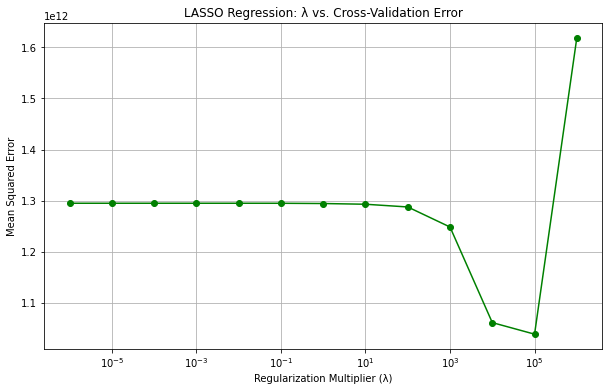

In [ ]:
# Define a range of alpha values for LASSO
lasso_alpha_range = np.logspace(-6, 6, 13)

# Setup LASSO model
lasso = Lasso(max_iter=10000, random_state=42)

# Setup the grid search with cross-validation for LASSO
lasso_param_grid = {'alpha': lasso_alpha_range}
lasso_cv = GridSearchCV(lasso, lasso_param_grid, cv=5, scoring='neg_mean_squared_error')

# Perform the grid search on the scaled training data
lasso_cv.fit(X_train_scaled, y_train)

# Get the best alpha value and print it
best_lasso_alpha = lasso_cv.best_params_['alpha']
print("Best LASSO λ: {:.6f}".format(best_lasso_alpha))

# Use the best alpha value found for LASSO
lasso_best = Lasso(alpha=best_lasso_alpha, max_iter=10000, random_state=42)
lasso_best.fit(X_train_scaled, y_train)

# Evaluate LASSO on the test set
y_pred_lasso = lasso_best.predict(X_test_scaled)
test_mse_lasso = mean_squared_error(y_test, y_pred_lasso)
print("Test MSE for LASSO: {:.4f}".format(test_mse_lasso))

# Plot LASSO alpha vs. MSE
mean_test_scores_lasso = -lasso_cv.cv_results_['mean_test_score']
plt.figure(figsize=(10, 6))
plt.semilogx(lasso_alpha_range, mean_test_scores_lasso, marker='o', linestyle='-', color='g')
plt.xlabel('Regularization Multiplier (λ)')
plt.ylabel('Mean Squared Error')
plt.title('LASSO Regression: λ vs. Cross-Validation Error')
plt.grid(True)
plt.show()